In [3]:
from utils import *
import os
from grid2op.utils import ScoreL2RPN2022
from l2rpn_baselines.utils import GymEnvWithRecoWithDN
import numpy as np
import re
import copy

2022-06-15 17:24:50.882713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 17:24:50.882737: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def create_bar_plot(dict_ts_survived, dn_ts_survived=[], reco_ts_survived=[], path=None, figsize=(10, 5)):
  scenarios = [i+1 for i in range(len(list(dict_ts_survived.values())[0]))] + ["Mean"]
  d = {"Scenarios": scenarios}
  
  if len(dn_ts_survived)>0:
    d.update({"Do Nothing": np.append(dn_ts_survived, dn_ts_survived.mean())})
  if len(reco_ts_survived)>0:
    d.update({"Reco": np.append(reco_ts_survived, reco_ts_survived.mean())})

  for key, value in dict_ts_survived.items():
    dict_ts_survived[key] = np.append(value, value.mean())

  d.update(dict_ts_survived)
       
  df = pd.DataFrame(d)
  tidy = df.melt(id_vars="Scenarios").rename(columns=str.title)
  tidy.rename(columns={"Value": "Survived steps", "Variable": "Agents"}, inplace=True)
  fig, ax1 = plt.subplots(figsize=figsize)
  sns.barplot(x="Scenarios", y="Survived steps", hue="Agents", data=tidy, palette=("magma"), ax=ax1)
  ax1.axhline(2017, color="black", label="Maximum time steps")
  ax1.axhline(0, color="black")
  plt.legend()
  sns.despine(fig)
  if path is not None:
    plt.savefig(path)
  plt.show()

In [6]:
import seaborn as sns

def create_box_plot(dict_ts_survived, dn_ts_survived, reco_ts_survived, path=None, figsize=(10, 5)):
  d = {"Scenarios": [],
       "Agents": [],
       "Survived steps": []}

  for i, v in enumerate(dn_ts_survived):
    d["Scenarios"].append(i)
    d["Agents"].append("DN")
    d["Survived steps"].append(v)
  
  for i, v in enumerate(reco_ts_survived):
    d["Scenarios"].append(i)
    d["Agents"].append("Reco")
    d["Survived steps"].append(v)

  for key, scenarios in dict_ts_survived.items():
    for i, values in enumerate(scenarios):
      for v in values:
        d["Scenarios"].append(i)
        d["Agents"].append(key)
        d["Survived steps"].append(v)

  df = pd.DataFrame(d)

  fig, ax1 = plt.subplots(figsize=figsize)
  sns.boxplot(x="Scenarios", y="Survived steps", hue="Agents", data=df, palette=("magma"), ax=ax1)
  ax1.axhline(2017, color="black", label="Maximum time steps")
  ax1.axhline(0, color="black")
  plt.legend()
  sns.despine(fig)
  if path is not None:
    plt.savefig(path)
  plt.show()

### Parameters of the agents to evaluate

In [7]:
save_path = "./saved_model/"
ENV_NAME = "l2rpn_wcci_2022_dev"
SCOREUSED = ScoreL2RPN2022
gymenv_class = GymEnvWithRecoWithDN
verbose = False
p = Parameters()
p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True # It causes errors during training
  
train_args = {}
train_args["gymenv_kwargs"] = {"safe_max_rho": 0.2}

values_to_test = np.array([1e-5, 3e-5, 1e-4])
var_to_test = "learning_rate"

agents_names = [d for d in os.listdir(save_path) if os.path.isdir(save_path + d)]
agents_names

['before_adding_attacks',
 'GymEnvWithRecoWithDN_2022-05-18_13-47_learning_rate_0',
 'before_full_normalization',
 'GymEnvWithRecoWithDN_2022-06-14_18-49_learning_rate_0',
 'GymEnvWithRecoWithDN_2022-05-20_18-52_learning_rate_0',
 'old',
 'GymEnvWithRecoWithDN_senior_2022-06-15_14-30_learning_rate_0']

In [8]:
def filter_chronics(x):
  # list_chronics = ["2050-01-03_31",
  #                  "2050-02-21_31",
  #                  "2050-03-07_31",
  #                  "2050-04-18_31"] # Names of chronics to keep
  # list_chronics = ["2050-01-03_31",
  #                     "2050-02-21_31",
  #                     "2050-03-07_31",
  #                     "2050-04-18_31",
  #                     "2050-05-09_31",
  #                     "2050-06-27_31",
  #                     "2050-07-25_31",
  #                     "2050-08-01_31",
  #                     "2050-09-26_31",
  #                     "2050-10-03_31",
  #                     "2050-11-14_31",
  #                     "2050-12-19_31",
  #                     ] # Names of chronics to keep
  list_chronics = ["2050-01-03_31",
                    "2050-02-21_31",
                    "2050-03-07_31",
                    "2050-04-18_31",
                    "2050-05-09_31",
                    "2050-06-27_31",
                    "2050-07-25_31",
                    "2050-08-01_31",
                    "2050-09-26_31",
                    "2050-10-03_31",
                    "2050-11-14_31",
                    "2050-12-19_31",
                    "2050-01-10_31",
                    "2050-02-07_31",
                    "2050-03-14_31",
                    "2050-04-11_31",
                    "2050-05-02_31",
                    "2050-06-20_31",
                    "2050-07-18_31",
                    "2050-08-08_31",
                    "2050-09-19_31",
                    "2050-10-10_31",
                    "2050-11-07_31",
                    "2050-12-12_31",
                    "2050-01-17_31",
                    "2050-02-14_31",
                    "2050-03-21_31",
                    "2050-04-25_31",
                    "2050-05-16_31",
                    "2050-06-13_31",
                    "2050-07-11_31",
                    "2050-08-15_31",
                    "2050-09-12_31",
                    "2050-10-17_31",
                    "2050-11-21_31",
                    "2050-12-05_31",
                    ] # Names of chronics to keep

  p = re.compile(".*(" + '|'.join([c + '$' for c in list_chronics]) + ")")
  return re.match(p, x) is not None

# filter_chronics = None

env_name_used = ENV_NAME + '_val' if filter_chronics is None else ENV_NAME
nb_scenario = 59 if filter_chronics is None else 36 #4

### Evaluation

In [8]:
from l2rpn_baselines.OptimCVXPY import OptimCVXPY
env = grid2op.make(env_name_used,
                   backend=LightSimBackend()
                   )

agent = OptimCVXPY(env.action_space,
                   env,
                   penalty_redispatching_unsafe=0.,
                   penalty_storage_unsafe=0.01,
                   penalty_curtailment_unsafe=0.01,
                   penalty_curtailment_safe=0.1,
                   penalty_redispatching_safe=0.1
                   )

In [9]:
agents_names = [#'GymEnvWithRecoWithDN_2022-05-18_13-47_learning_rate_0',
                'GymEnvWithRecoWithDN_2022-06-14_18-49_learning_rate_0',
                'GymEnvWithRecoWithDN_senior_2022-06-15_14-30_learning_rate_0']
# agents_names = [el for el in os.listdir(save_path) if re.match(r'GymEnv.*', el) is not None]
# agents_names = []

# agents_dict = {"optimizer1":agent}
agents_dict = {}
agents_dict.update({agent_name:None for agent_name in agents_names})

In [10]:
total_results = np.zeros((len(agents_dict), nb_scenario, 3))
for i, (agent_name, my_agent) in enumerate(agents_dict.items()):
  results = eval_agent(env_name_used,
            nb_scenario=nb_scenario,
            agent_name=agent_name,
            load_path=save_path,
            SCOREUSED=SCOREUSED,
            gymenv_class=gymenv_class,
            verbose=verbose,
            gymenv_kwargs=train_args["gymenv_kwargs"] if var_to_test!="gymenv_kwargs" else values_to_test[i],
            param=p,
            filter_fun=filter_chronics,
            my_agent=my_agent
            )
  for k in range(3):
    total_results[i, :, k]=np.array(results[k])
  # print(results)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/grid2op/Observation/baseObservation.py:2904: RuntimeWarning: invalid value encountered in multiply
  res = 1.0 * self._thermal_limit


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [19]:
# total_results = np.concatenate((np.load("./pre_train/total_results/total_results_2022-06-07_17-07.npy"), 
#                                 np.load("./pre_train/total_results/total_results_2022-06-02_16-08.npy")), axis=0)

total_results = np.concatenate((np.load("./pre_train/total_results/total_results_2022-06-09_21-03.npy"), 
                                total_results), axis=0)

# total_results = np.load("./pre_train/total_results/total_results_2022-06-07_17-07.npy")
nb_agents = total_results.shape[0]
# agent_name = [f"optim_{i}" for i in range(nb_agents)]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 36 and the array at index 1 has size 59

In [11]:
total_results.shape, agents_names

((2, 59, 3),
 ['GymEnvWithRecoWithDN_2022-06-14_18-49_learning_rate_0',
  'GymEnvWithRecoWithDN_senior_2022-06-15_14-30_learning_rate_0'])

In [12]:
# Agregation des initialisations si il y en a plusieurs et post-traitement

# nb_init_train = 4
nb_init_train = 1


if nb_init_train > 2:
    total_results_mean = np.zeros((total_results.shape[0]//nb_init_train, nb_scenario, 3))
    total_results_std = np.zeros((total_results.shape[0]//nb_init_train, nb_scenario, 3))
    total_results_best = np.zeros((total_results.shape[0], total_results.shape[1], 2))
    total_results_best_mean = np.zeros((total_results.shape[0]//nb_init_train, 2))
    total_results_worst = np.zeros((total_results.shape[0], total_results.shape[1], 2))
    total_results_worst_mean = np.zeros((total_results.shape[0]//nb_init_train, 2))
    dict_ts_survived_init = {}
    for i_val in range(total_results_mean.shape[0]):
        pattern = re.compile('.*' + str(i_val) + '$')
        index = np.where([re.match(pattern, el) is not None for el in agents_names])[0]
        dict_ts_survived_init.update({f"Agent_{i_val}" : total_results[index, :, 0].T})
        total_results_mean[i_val] = np.mean(total_results[index], axis=0)
        total_results_std[i_val] = np.std(total_results[index], axis=0)
        total_results_best[index] = np.mean(total_results[index][:, :, [0]] > (total_results[index][:, :, [1,2]]+12), axis=1)
        total_results_best_mean[i_val] = np.mean(total_results_best[index], axis=0)
        total_results_worst[index] = np.mean(total_results[index][:, :, [0]] < (total_results[index][:, :, [1,2]]+12), axis=1)
        total_results_worst_mean[i_val] = np.mean(total_results_worst[index], axis=0)

else:
    total_results_mean = copy.deepcopy(total_results)
    total_results_best_mean = np.mean(total_results[:, :, [0]] > (total_results[:, :, [1,2]]+12), axis=1)
    total_results_worst_mean = np.mean(total_results[:, :, [0]] < (total_results[:, :, [1,2]]+12), axis=1)
    dict_ts_survived_scenario = {}
    dict_ts_survived_scenario_diff_DN = {}
    dict_ts_survived_scenario_diff_Reco = {}
    for i_val in range(total_results_mean.shape[0]):
        dict_ts_survived_scenario.update({f"Agent_{i_val}" : total_results[[i_val], :, 0]})
        dict_ts_survived_scenario_diff_DN.update({f"Agent_{i_val}-DN" : total_results[[i_val], :, 0]-total_results[[i_val], :, 1]})
        dict_ts_survived_scenario_diff_Reco.update({f"Agent_{i_val}-Reco" : total_results[[i_val], :, 0]-total_results[[i_val], :, 2]})
    dict_ts_survived_scenario.update({"DN_Agent": [total_results_mean[0, :, 1]], "Reco_Agent": [total_results_mean[0, :, 2]]})
    dict_ts_survived_scenario_diff_Reco.update({"DN-Reco": [total_results_mean[0, :, 1]-total_results_mean[0, :, 2]]})
    dict_ts_survived_scenario_diff_DN.update({"Reco-DN": [total_results_mean[0, :, 1]-total_results_mean[0, :, 2]]})


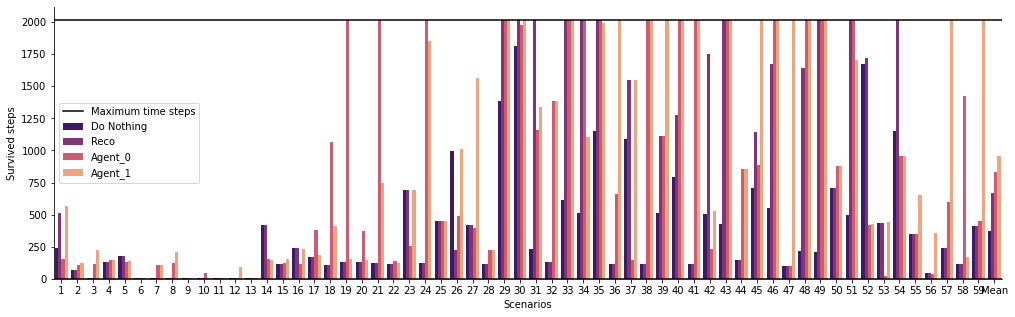

In [13]:
create_bar_plot({f"Agent_{i}" : total_results_mean[i, :, 0] for i in range(total_results_mean.shape[0])},
                    total_results_mean[0, :, 1], 
                    total_results_mean[0, :, 2],
                    figsize=(17,5))

if nb_init_train > 1:
    create_bar_plot({f"Agent_{i}" : total_results_std[i, :, 0] for i in range(total_results_std.shape[0])},
                    total_results_std[0, :, 1], 
                    total_results_std[0, :, 2])
    create_box_plot(dict_ts_survived_init, total_results_mean[0, :, 1], total_results_mean[0, :, 2])

In [18]:
np.median(total_results, axis=1)/12 # Performances moyennes en nombre d'heures

array([[37.25      , 17.66666667, 18.41666667],
       [57.75      , 17.66666667, 18.41666667]])

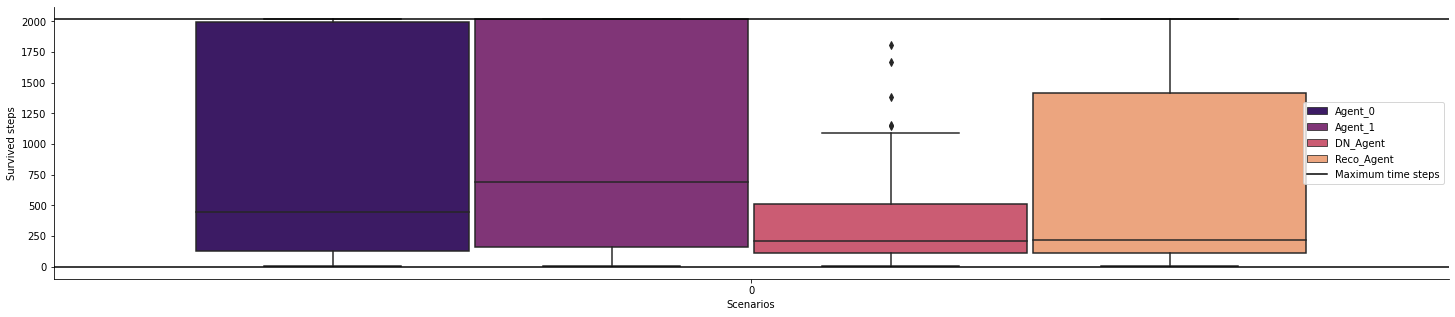

In [15]:
# Un boxplot rassemble nb_scenatio chroniques et correspond à un agent
create_box_plot(dict_ts_survived_scenario, [],  [], figsize=(25,5))

In [26]:
[{"penalty_storage_unsafe": penalty_storage_unsafe, 
                        "penalty_curtailment_unsafe":penalty_curtailment_unsafe,
                        "rho_danger":rho_danger}
                        for penalty_storage_unsafe in [0.01, 0.04]
                        for penalty_curtailment_unsafe in [0.01, 0.04]
                        for rho_danger in [0.9, 0.97]
                    ]

[{"penalty_redispatching_unsafe":10, 
                        "penalty_storage_unsafe": penalty_storage_unsafe, 
                        "penalty_curtailment_unsafe":penalty_curtailment_unsafe,
                        "rho_safe":rho_safe,
                        "rho_danger":0.97,
                        "margin_th_limit":0.93,
                        "alpha_por_error":0.5}
                        for penalty_storage_unsafe in [0.04, 0.07]
                        for penalty_curtailment_unsafe in [0.04, 0.07]
                        for rho_safe in [0.6, 0.9]
                    ]

[{'penalty_redispatching_unsafe': 10,
  'penalty_storage_unsafe': 0.04,
  'penalty_curtailment_unsafe': 0.04,
  'rho_safe': 0.6,
  'rho_danger': 0.97,
  'margin_th_limit': 0.93,
  'alpha_por_error': 0.5},
 {'penalty_redispatching_unsafe': 10,
  'penalty_storage_unsafe': 0.04,
  'penalty_curtailment_unsafe': 0.04,
  'rho_safe': 0.9,
  'rho_danger': 0.97,
  'margin_th_limit': 0.93,
  'alpha_por_error': 0.5},
 {'penalty_redispatching_unsafe': 10,
  'penalty_storage_unsafe': 0.04,
  'penalty_curtailment_unsafe': 0.07,
  'rho_safe': 0.6,
  'rho_danger': 0.97,
  'margin_th_limit': 0.93,
  'alpha_por_error': 0.5},
 {'penalty_redispatching_unsafe': 10,
  'penalty_storage_unsafe': 0.04,
  'penalty_curtailment_unsafe': 0.07,
  'rho_safe': 0.9,
  'rho_danger': 0.97,
  'margin_th_limit': 0.93,
  'alpha_por_error': 0.5},
 {'penalty_redispatching_unsafe': 10,
  'penalty_storage_unsafe': 0.07,
  'penalty_curtailment_unsafe': 0.04,
  'rho_safe': 0.6,
  'rho_danger': 0.97,
  'margin_th_limit': 0.93,
  

In [16]:
for i in range(total_results_best_mean.shape[0]):
    print(f"Agent_{i} has been better than DN_Agent for {total_results_best_mean[i,0]*100} % of the scenarios")
    print(f"Agent_{i} has been better than Reco_Agent for {total_results_best_mean[i,1]*100} % of the scenarios")

print()
for i in range(total_results_best_mean.shape[0]):
    print(f"Agent_{i} has been worse than DN_Agent for {total_results_worst_mean[i,0]*100} % of the scenarios")
    print(f"Agent_{i} has been worse than Reco_Agent for {total_results_worst_mean[i,1]*100} % of the scenarios")

Agent_0 has been better than DN_Agent for 62.71186440677966 % of the scenarios
Agent_0 has been better than Reco_Agent for 45.76271186440678 % of the scenarios
Agent_1 has been better than DN_Agent for 72.88135593220339 % of the scenarios
Agent_1 has been better than Reco_Agent for 55.932203389830505 % of the scenarios

Agent_0 has been worse than DN_Agent for 37.28813559322034 % of the scenarios
Agent_0 has been worse than Reco_Agent for 54.23728813559322 % of the scenarios
Agent_1 has been worse than DN_Agent for 27.11864406779661 % of the scenarios
Agent_1 has been worse than Reco_Agent for 44.06779661016949 % of the scenarios


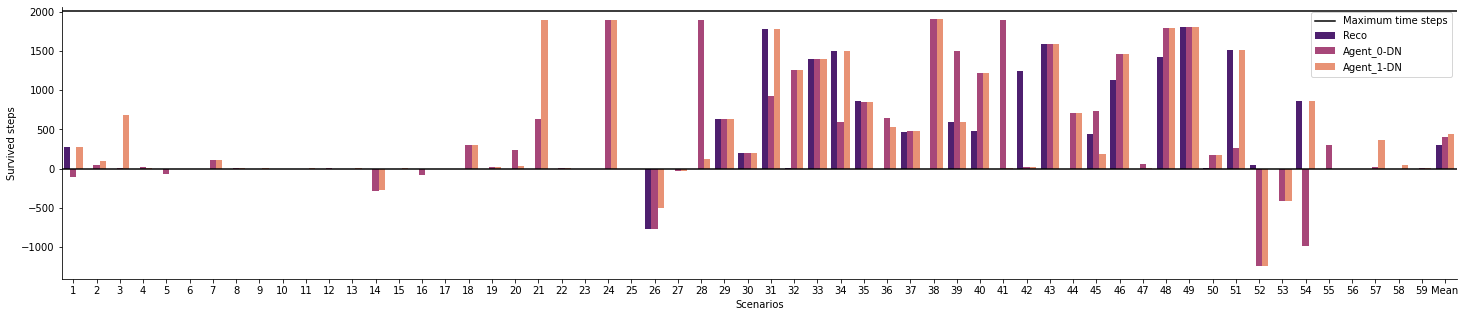

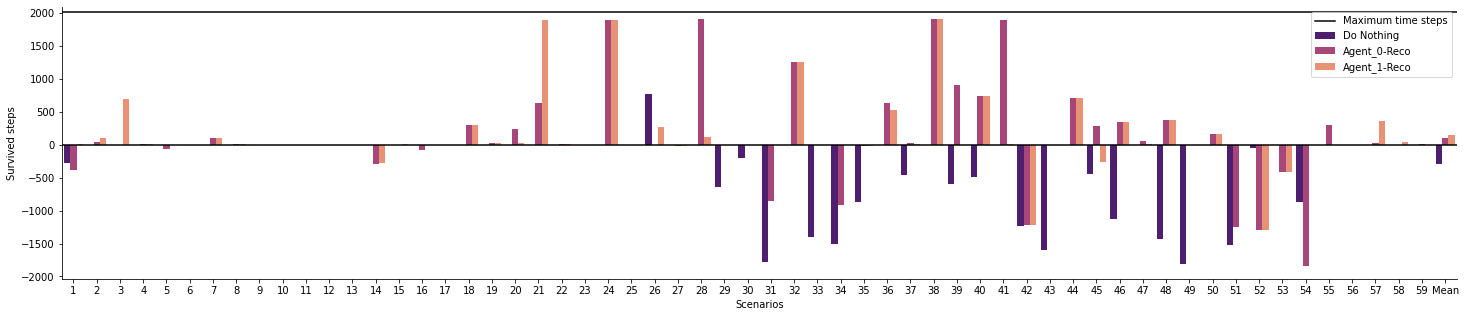

In [25]:
create_bar_plot({f"Agent_{i}-DN" : total_results_mean[i, :, 0] - total_results_mean[i, :, 1] for i in range(total_results_mean.shape[0])},
                    [], 
                    total_results_mean[0, :, 2]-total_results_mean[0, :, 1],
                    figsize=(25,5))

create_bar_plot({f"Agent_{i}-Reco" : total_results_mean[i, :, 0] - total_results_mean[i, :, 2] for i in range(total_results_mean.shape[0])},
                    total_results_mean[0, :, 1]-total_results_mean[0, :, 2], 
                    [],
                    figsize=(25,5))

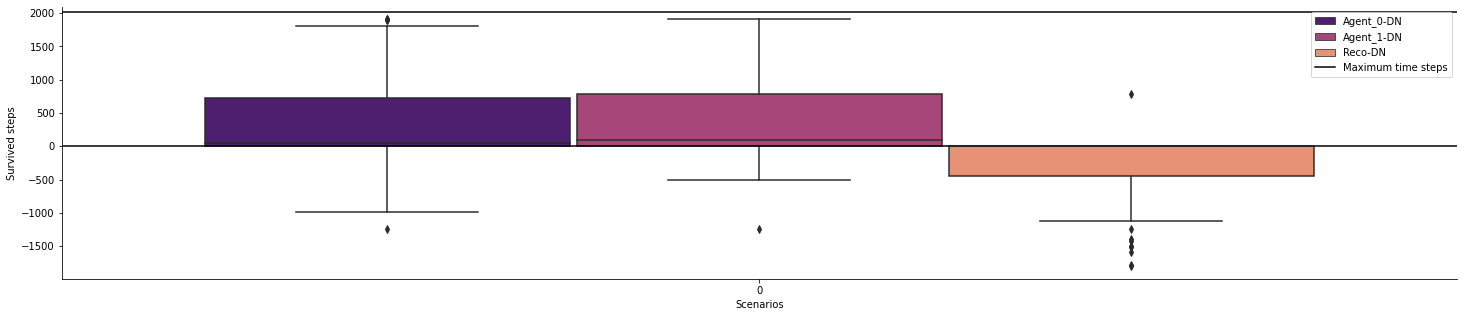

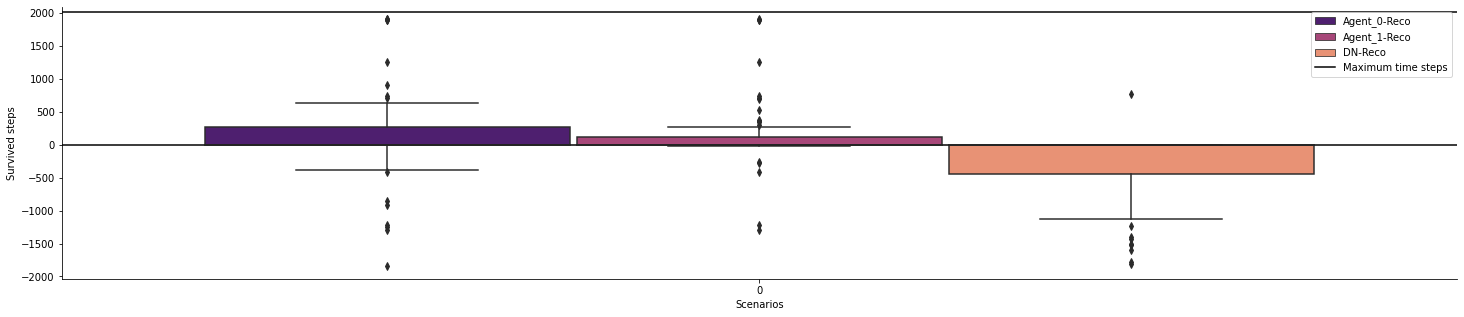

In [27]:
create_box_plot(dict_ts_survived_scenario_diff_DN, [],  [], figsize=(25,5))

create_box_plot(dict_ts_survived_scenario_diff_Reco, [],  [], figsize=(25,5))

## Supervised learning curves

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
loss_list = np.load("pre_train/student/GymEnvWithRecoWithDN_student_2022-06-15_10-36/train_test_loss_list.npz", allow_pickle=True)

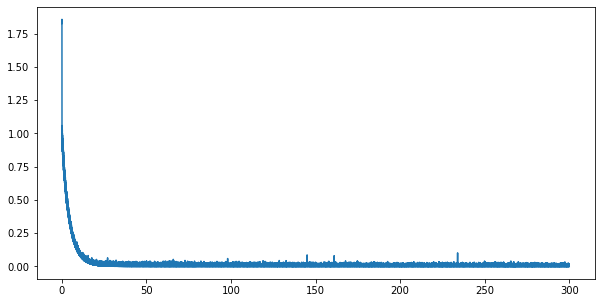

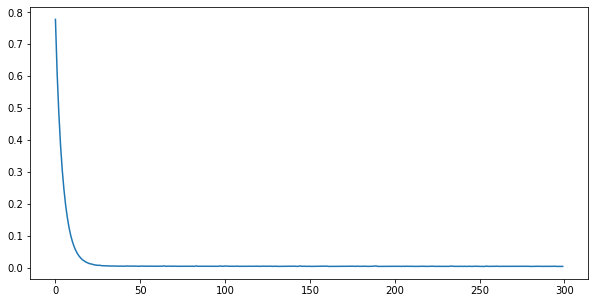

In [3]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(423600)/1412, np.array(loss_list.get("train_loss_list")))
# plt.yscale("log")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.array(loss_list.get("test_loss_list")))
# plt.yscale("log")
plt.show()

## Varying seeds

In [50]:
from grid2op.Agent import RecoPowerlineAgent, DoNothingAgent
from grid2op.Runner import Runner
from examples.ppo_stable_baselines.C_evaluate_trained_model import load_agent
from grid2op.Chronics import MultifolderWithCache
from tqdm import tqdm

with open("./preprocess_obs.json", "r", encoding="utf-8") as f:
    obs_space_kwargs = json.load(f)
with open("./preprocess_act.json", "r", encoding="utf-8") as f:
    act_space_kwargs = json.load(f)

In [69]:
def vary_seeds(env_name, save_path, nb_scenario, gymenv_class, agents_names=[], gymenv_kwargs={}, nb_init_env_seeds=3, filter_chronics=None, agents_dict = {}, param=p):
    env = grid2op.make(env_name,
                    reward_class=CustomReward2,
                    backend=LightSimBackend(),
                    chronics_class=MultifolderWithCache,
                    param=param)

    agents_dict.update({"DoNothingAgent":DoNothingAgent(env.action_space),
                    "RecoPowerlineAgent":RecoPowerlineAgent(env.action_space)})

    agents_dict.update({agent_name:load_agent(env, 
                                load_path=save_path, 
                                name=agent_name, 
                                gymenv_class=gymenv_class, 
                                gymenv_kwargs=gymenv_kwargs,
                                obs_space_kwargs=obs_space_kwargs,
                                act_space_kwargs=act_space_kwargs) for agent_name in agents_names})

    max_int = np.iinfo(dt_int).max
    env_seeds_list=[np.random.randint(low=0,
                                high=max_int,
                                size=nb_scenario,
                                dtype=dt_int) for _ in range(nb_init_env_seeds)]

    results_list = []
    results_dict = {}
    for agent_name, agent in agents_dict.items():
        results_dict[agent_name]=[]
        for env_seeds in tqdm(env_seeds_list, desc = agent_name):
            results = eval_agent(env_name,
                        nb_scenario,
                        agent_name,
                        save_path,
                        SCOREUSED,
                        gymenv_class,
                        verbose=False,
                        gymenv_kwargs=gymenv_kwargs,
                        param=p,
                        filter_fun=filter_chronics,
                        env_seeds=env_seeds,
                        my_agent=agent)
            results_dict[agent_name].append(results[0])
            results_list.append([env_seeds, agent_name, results[0]])
    results_dict = {k: np.array(v).T for k,v in results_dict.items()}
    return results_dict

In [ ]:
agents_names = ['GymEnvWithRecoWithDN_2022-05-20_18-52_learning_rate_0']
agents_names = []

results_dict = vary_seeds(agents_names=agents_names,
                            env_name =env_name_used, 
                            save_path=save_path, 
                            gymenv_class=gymenv_class,
                            gymenv_kwargs=train_args["gymenv_kwargs"] if var_to_test!="gymenv_kwargs" else values_to_test[i],
                            nb_scenario=nb_scenario,
                            filter_chronics=filter_chronics,
                            nb_init_env_seeds=1,
                            agents_dict={}
                            )

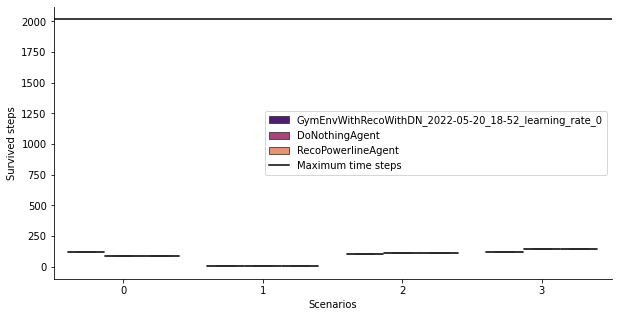

({'GymEnvWithRecoWithDN_2022-05-20_18-52_learning_rate_0': array([[121],
         [  3],
         [105],
         [120]]),
  'DoNothingAgent': array([[ 86],
         [  3],
         [115],
         [142]]),
  'RecoPowerlineAgent': array([[ 86],
         [  3],
         [115],
         [142]])},
 None)

In [53]:
results_dict, create_box_plot(results_dict, [], [])

In [19]:
# create_bar_plot({k:el.T[0] for k,el in results_dict.items()}, [], [])